#ALL IMPORTS

In [1]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms as T, models
import glob
import torch.optim as optim
import time

import cv2
%matplotlib inline
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
elif torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: cuda:0


In [3]:
data_dir = 'RSI-CB256/data/'
print(os.listdir(data_dir))

['cloudy', 'desert', 'green_area', 'water']


## CUSTOM DATA LOADER

In [4]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"desert" : 0, "water": 1,"green_area": 2,"cloudy": 3}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

##SPLITTING DATA

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [6]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))

print(len(data_loader_val))

['RSI-CB256/data\\cloudy', 'RSI-CB256/data\\desert', 'RSI-CB256/data\\green_area', 'RSI-CB256/data\\water']
[['RSI-CB256/data\\cloudy\\train_10021.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10043.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10070.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10081.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10096.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_101.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10128.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10166.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10173.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10177.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10201.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10224.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10225.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10231.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10263.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10265.jpg', 'cloudy'], ['RSI-CB256/d

### PLOTING DATA

In [7]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


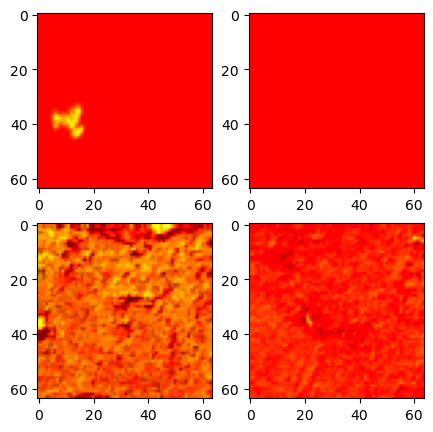

In [8]:
plot_data_loader(data_loader_test,[2,2])

###MODEL

In [9]:
#  model = models.densenet121(pretrained=False)
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights=None)
model.classifier=nn.Linear(in_features=1024, out_features=4, bias=True)
    

Using cache found in C:\Users\solan/.cache\torch\hub\pytorch_vision_v0.10.0


In [10]:
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

###TRAINING LOOPS

In [11]:
count_parameters(model)


+------------------------------------------------+------------+
|                    Modules                     | Parameters |
+------------------------------------------------+------------+
|             features.conv0.weight              |    9408    |
|             features.norm0.weight              |     64     |
|              features.norm0.bias               |     64     |
| features.denseblock1.denselayer1.norm1.weight  |     64     |
|  features.denseblock1.denselayer1.norm1.bias   |     64     |
| features.denseblock1.denselayer1.conv1.weight  |    8192    |
| features.denseblock1.denselayer1.norm2.weight  |    128     |
|  features.denseblock1.denselayer1.norm2.bias   |    128     |
| features.denseblock1.denselayer1.conv2.weight  |   36864    |
| features.denseblock1.denselayer2.norm1.weight  |     96     |
|  features.denseblock1.denselayer2.norm1.bias   |     96     |
| features.denseblock1.denselayer2.conv1.weight  |   12288    |
| features.denseblock1.denselayer2.norm2

6957956

In [12]:

optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()



In [13]:
device


device(type='cuda', index=0)

In [ ]:
num_epochs = 2
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        images = data[0].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                      (correct / total) * 100))
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

In [ ]:
# torch.save(model.state_dict(), 'Satellite-image-classification-densenet.pt')
torch.save(model, "Satellite-image-classification-densenet.pth")

In [ ]:
%ls

In [ ]:
# model = models.densenet121(pretrained=False)
# model.load_state_dict(torch.load('Satellite-image-classification-densenet.pt'))

model=torch.load('Satellite-image-classification-densenet.pth')
model.eval()

### MODEL EVOLUTION

In [ ]:
model.to(device)
model.eval() 
with torch.no_grad(): 
 correct = 0
 total = 0
 for data in data_loader_test:
  images, labels = data[0].to(device), data[1].to(device)
  labels=torch.flatten(labels)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))